In [10]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
from scipy.ndimage import label
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

RAW_DIRECTORY=os.getenv('nnUNet_raw', default='data/nnUNet_raw')
DATASET_ID = 501


def get_dataset_dir(base_dir, dataset_id):
    prefix = f"Dataset{int(dataset_id):03d}_"
    matches = [
        p for p in Path(base_dir).iterdir()
        if p.is_dir() and p.name.startswith(prefix)
    ]

    if not matches:
        raise FileNotFoundError(f"No dataset found for id {dataset_id}")
    if len(matches) > 1:
        raise RuntimeError(
            f"Multiple datasets found for id {dataset_id}: {matches}")

    return matches[0]


def analyze_dataset(label_dir):
    records = []
    files = [f for f in os.listdir(label_dir) if f.endswith('.nii.gz')]

    for f in tqdm(files):
        img = nib.load(os.path.join(label_dir, f))
        data = (img.get_fdata() > 0).astype(np.uint8)

        # Identify individual components
        labeled, n = label(data)
        if n > 0:
            vols = [np.sum(labeled == i) for i in range(1, n + 1)]
            records.append({
                'Case ID': f,
                'Instance Count': n,
                'Min Volume': min(vols),
                'Max Volume': max(vols),
                'Total Volume': sum(vols),
                'Volumetric Disparity': max(vols) / max(min(vols), 1)
            })

    df = pd.DataFrame(records)
    # Define outliers as top 5% or specific high-impact cases
    outliers = df[(df['Instance Count'] > df['Instance Count'].quantile(0.95)) |
                  (df['Volumetric Disparity'] > df['Volumetric Disparity'].quantile(0.95))]
    return df, outliers


label_path = f"{get_dataset_dir(RAW_DIRECTORY, DATASET_ID)}/labelsTr"

dataset_stats, outliers = analyze_dataset(label_path)
print(outliers)

100%|██████████| 105/105 [00:40<00:00,  2.57it/s]

             Case ID  Instance Count  Min Volume  Max Volume  Total Volume  \
3    Mets_062.nii.gz              17           1       36916         54151   
10   Mets_120.nii.gz             206           1        2305         13177   
20   Mets_274.nii.gz               2           1       27399         27400   
25   Mets_173.nii.gz               9           1        7171         13578   
31   Mets_024.nii.gz              82           1         316          2353   
61   Mets_134.nii.gz             124           1         778          5886   
64   Mets_052.nii.gz             203           1         293          4299   
94   Mets_314.nii.gz              82           1         127          2747   
95   Mets_266.nii.gz              98           1       14079         27759   
96   Mets_049.nii.gz              19           1       10654         14160   
102  Mets_244.nii.gz              14           1       15378         19337   

     Volumetric Disparity  
3                 36916.0  
10     

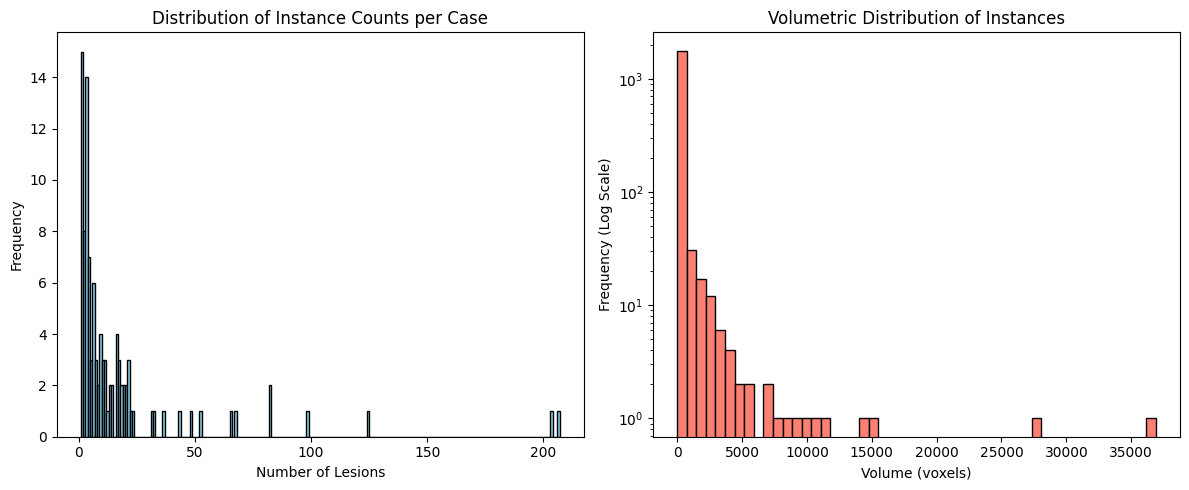

In [ ]:
def plot_dataset_characteristics(stats):
    all_volumes = [v for s in stats for v in s['volumes']]
    n_instances_per_case = [s['n_instances'] for s in stats]

    plt.figure(figsize=(12, 5))

    # Plot 1: Instance Distribution
    plt.subplot(1, 2, 1)
    plt.hist(n_instances_per_case, bins=range(
        1, max(n_instances_per_case)+2), color='skyblue', edgecolor='black')
    plt.title("Distribution of Instance Counts per Case")
    plt.xlabel("Number of Instances")
    plt.ylabel("Frequency")

    # Plot 2: Volumetric Disparity (Log Scale)
    plt.subplot(1, 2, 2)
    plt.hist(all_volumes, bins=50, color='salmon', edgecolor='black')
    plt.yscale('log')  # Log scale to see tiny lesions
    plt.title("Volumetric Distribution of Instances")
    plt.xlabel("Volume (voxels)")
    plt.ylabel("Frequency (Log Scale)")

    plt.tight_layout()
    plt.show()

plot_dataset_characteristics(dataset_stats)